In [1]:
!nvidia-smi

Thu Nov  2 07:16:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            3
    BogoMIPS:            4000.29
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numba import cuda, jit
import math
import time


def cpu_bilateral(img, buffer):
    result = np.zeros_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            sum = 0.
            weighted_sum = 0.
            for i in range(x - buffer[1], x + buffer[1] + 1):
                for j in range(y - buffer[1], y + buffer[1] + 1):
                     if i >= 0 and i < img.shape[0] and j >= 0 and j < img.shape[1]:
                        diff = int(img[x, y]) - int(img[i, j])
                        weight = np.exp(-(diff**2) / (2 * buffer[0] ** 2))
                        sum += weight * img[i, j]
                        weighted_sum += weight
            result[x, y] = sum / weighted_sum if weighted_sum != 0 else img[x, y]
    return result


@cuda.jit
def kern(img, result, buffer):
    idx, jdx = cuda.grid(2)
    if idx < img.shape[0] and jdx < img.shape[1]:
        x = idx
        y = jdx
        sum = 0.
        weighted_sum = 0.
        for i in range(x - buffer[1], x + buffer[1] + 1):
            for j in range(y - buffer[1], y + buffer[1] + 1):
                if i >= 0 and i < img.shape[0] and j >= 0 and j < img.shape[1]:
                    diff = img[x, y] - img[i, j]
                    weight = math.exp(-((diff ** 2) / (2 * buffer[0] ** 2)))
                    sum += weight * img[i, j]
                    weighted_sum += weight
        result[x, y] = sum / weighted_sum if weighted_sum != 0 else img[x, y]


def gpu_bilateral(img, buffer):
    threads_per_block = (16,16)
    blocks_per_grid = (math.ceil(img.shape[0]/threads_per_block[0]), math.ceil(img.shape[1]/threads_per_block[1]))

    startp = cuda.event()
    endp = cuda.event()
    startp.record()

    img_dev = cuda.to_device(img)
    result_dev = cuda.to_device(np.zeros_like(img, dtype=np.float32))
    buffer_dev = cuda.to_device(np.array(buffer, dtype=np.float32))

    kern[blocks_per_grid, threads_per_block](img_dev, result_dev, buffer_dev)
    endp.record()
    endp.synchronize()
    elapsedp = cuda.event_elapsed_time(startp, endp)
    return result_dev.copy_to_host(), elapsedp / 1000


In [ ]:
!wget https://github.com/IraMeis/HPC-2023/raw/main/lr3/cat_1000.bmp \
https://github.com/IraMeis/HPC-2023/raw/main/lr3/cat_224.png \
https://github.com/IraMeis/HPC-2023/raw/main/lr3/cat_512.png

In [17]:
imgs = [cv2.imread(f'/content/{im}', cv2.IMREAD_GRAYSCALE) for im in ['cat_224.png', 'cat_512.png', 'cat_1000.bmp']]

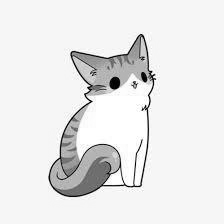

In [18]:
img = imgs[0]
cv2_imshow(img)


CPU:



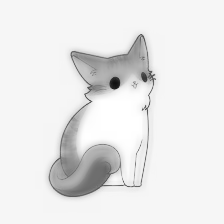


GPU:



<ipython-input-19-f679f2f81fcf>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_gpu, result_time_gpu  = np.array(gpu_bilateral(img, buff))


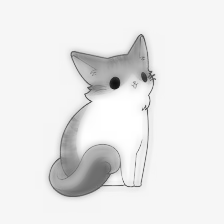


CPU:  17.249826192855835
GPU:  0.009690367698669433
Acceleration:  1780.1002737207152


In [19]:
blur = 100
d = 5
buff = [blur, d]

start = time.time()
result_cpu = np.array(cpu_bilateral(img, buff))
result_time_cpu = time.time() - start

print("\nCPU:\n")
cv2_imshow(result_cpu)

result_gpu, result_time_gpu  = np.array(gpu_bilateral(img, buff))

print("\nGPU:\n")
cv2_imshow(result_gpu)

print("\nCPU: ", result_time_cpu)
print("GPU: ", result_time_gpu)
print("Acceleration: ", result_time_cpu / result_time_gpu)